In [16]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(42)
sns.set_style('white')
sys.path.insert(0, '../')
sys.path.insert(0, '../MIMIC_notebooks/')

import torch

from scipy.stats import ttest_rel
from scipy.sparse import load_npz
from scipy.stats import combine_pvalues
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from baselines import cdmm
from sarpu.pu_learning import *
from eval_fs import eval_relative_prior
from fig_helpers import add_metrics_to_df
from method import train_relative_estimator
from mimic_helper_fs import get_ids_of_ethnicity
from paths import FIG_DIR
hue_order = ['supervised', 'negative', 'scar-km2', 'sar-em', 'ours']
plotted_methods = ['supervised', 'negative','scar-km2', 'sar-em',  'ours']
method_name_dict = {"supervised": "Supervised", "negative": "Negative", "scar-c": "SCAR-C",
                    'scar-km2': 'KM2', "sar-em": "EM", "ours": "PURPLE"}

val_loss_key = 'auc'

orig = sns.color_palette('colorblind')
method_colors = [orig[1], orig[0], orig[4], orig[3], orig[2]]
method_colors = ['#4daf4a', '#e41a1c', '#377eb8', '#ff7f00', '#984ea3']
figsize=(6, 4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load results

In [24]:
ipv_our_results = pd.read_csv('results/ipv_ours_semisimulated_results')
ipv_our_results = ipv_our_results.sort_values([val_loss_key], ascending=False).groupby(['labeling_frequency_g2', 'run']).head(1)
ipv_results_df = pd.concat([pd.read_csv('results/ipv_sar-em_semisimulated_results'),
                        pd.read_csv('results/ipv_supervised_semisimulated_results'),
                        pd.read_csv('results/ipv_cdmm_semisimulated_results'),
                        pd.read_csv('results/ipv_scar-km2_semisimulated_results'),
                        pd.read_csv('results/ipv_negative_semisimulated_results'),
                        ipv_our_results], ignore_index=True)

random_our_results = pd.read_csv('random_ours_semisimulated_results')
random_our_results = random_our_results.sort_values([val_loss_key], ascending=False).groupby(['labeling_frequency_g2', 'run']).head(1)
random_results_df = pd.concat([pd.read_csv('results/random_supervised_semisimulated_results'),
                        pd.read_csv('results/random_scar-km2_semisimulated_results'),
                        pd.read_csv('results/random_sar-em_semisimulated_results'),
                        random_our_results,
                        pd.read_csv('results/random_negative_semisimulated_results')], ignore_index=True)

corr_our_results = pd.read_csv('results/corr4_ours_semisimulated_results')
#corr_our_results = corr_our_results.sort_values([val_loss_key], ascending=False).groupby(['labeling_frequency_g2', 'run']).head(1)
corr_results_df = pd.concat([pd.read_csv('results/corr4_supervised_semisimulated_results'),
                        pd.read_csv('results/corr4_scar-km2_semisimulated_results'),
                        pd.read_csv('results/corr4_sar-em_semisimulated_results'),
                        corr_our_results,
                        pd.read_csv('results/corr4_negative_semisimulated_results')], 
                        ignore_index=True)

high_rp_our_results = pd.read_csv('results/high_rp_ours_semisimulated_results')
high_rp_our_results = high_rp_our_results.sort_values([val_loss_key], ascending=False).groupby(['group', 'labeling_frequency_g2', 'seed']).head(1)
high_rp_results_df = pd.concat([pd.read_csv('results/high_rp_supervised_semisimulated_results'),
                        pd.read_csv('results/high_rp_scar-km2_semisimulated_results'),
                        pd.read_csv('results/saved_high_rp_sar-em_semisimulated_results_1'),
                        pd.read_csv('results/saved_high_rp_sar-em_semisimulated_results'),
                        high_rp_our_results,
                        pd.read_csv('results/high_rp_negative_semisimulated_results')], 
                        ignore_index=True)

high_rp_results_df = add_metrics_to_df(high_rp_results_df)
high_rp_results_df = high_rp_results_df[high_rp_results_df['group'] == 'BLACK/AFRICAN AMERICAN']

random_results_df = add_metrics_to_df(random_results_df)
ipv_results_df = add_metrics_to_df(ipv_results_df)
corr_results_df = add_metrics_to_df(corr_results_df)

## Plot results

<ipython-input-25-243b1ec8dd6e>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(['', '', '0.5x', '1.0x', '2.0x', '4.0x'])


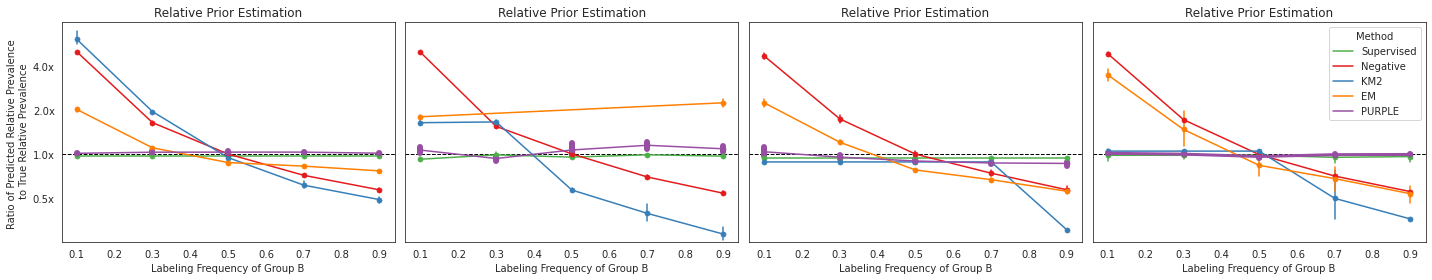

In [25]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
results_dfs = [random_results_df, high_rp_results_df, corr_results_df, ipv_results_df]
names = ['Random', 'High Relative Prevalence', 'Correlated Symptoms', 'Recognized Symptoms']
for i, (df, name) in enumerate(zip(results_dfs, names)):
    ax = axs[i]
    g = sns.lineplot(x='labeling_frequency_g2', y='rel_prior_err_pct', 
             marker='o', hue='method', hue_order=hue_order, palette=method_colors,
             data=df, err_style='bars', markeredgecolor=None, 
            markersize=5, ax=ax)
    
    linewidth=3
    for line in plt.gca().lines[8:]:
        line.set_linewidth(linewidth)
    plt.setp(g.collections[-1], linewidth=linewidth*2) #for the markers

    g.set_yscale('log', base=2)
    g.set_ylim(.25, 8)
    if i == 0:
        g.set_yticklabels(['', '', '0.5x', '1.0x', '2.0x', '4.0x'])
    else:
        g.set_yticklabels([])
    ax.set_title("Relative Prior Estimation")
    ax.set_xlabel("Labeling Frequency of Group B")
    ax.set_ylabel('')
    if i == 0:
        ax.set_ylabel("Ratio of Predicted Relative Prevalence \n to True Relative Prevalence")
    
    if i == 3:
        new_labels = [method_name_dict[method_name] for method_name in hue_order]
        for t, l in zip(g.get_legend().texts, new_labels): t.set_text(l)
        g.get_legend().set_title('Method')
    else:
        g.get_legend().remove()

    g.axhline(y=1.0, color='black', linestyle='--', zorder=1,
                   linewidth=1)
plt.tight_layout()
plt.savefig(FIG_DIR + 'semisynthetic.pdf', format='pdf', dpi=600)

# Statistical test

In [20]:
max_pvals = []
for label_freq in set(random_results_df['labeling_frequency_g2']):
    pvals = []
    for method in plotted_methods: 
        if method == 'ours' or method == 'supervised':
            continue
        expmt_results = random_results_df[random_results_df['labeling_frequency_g2'] == label_freq]
        our_results = expmt_results[expmt_results['method'] == 'ours']
        other_method_results = expmt_results[expmt_results['method'] == method]
        x, pval = ttest_rel(our_results['log_rel_prior_err_pct'], other_method_results['log_rel_prior_err_pct'])
        pvals.append(pval)
        print("Label Frequency: ", label_freq, "Method: ", method, 'p-val: ', pval)
    max_pvals.append(np.max(pvals))
print(combine_pvalues(max_pvals))


Label Frequency:  0.1 Method:  negative p-val:  5.517814230733966e-08
Label Frequency:  0.1 Method:  scar-km2 p-val:  1.032604475637853e-05
Label Frequency:  0.1 Method:  sar-em p-val:  2.1235550091093312e-06
Label Frequency:  0.5000000000000001 Method:  negative p-val:  0.03226537790253153
Label Frequency:  0.5000000000000001 Method:  scar-km2 p-val:  0.1554286215661584
Label Frequency:  0.5000000000000001 Method:  sar-em p-val:  4.458823786770916e-05
Label Frequency:  0.3 Method:  negative p-val:  1.2668917496607036e-06
Label Frequency:  0.3 Method:  scar-km2 p-val:  1.2099976031987969e-06
Label Frequency:  0.3 Method:  sar-em p-val:  0.003681430493700012
Label Frequency:  0.9000000000000001 Method:  negative p-val:  1.2553320205273451e-06
Label Frequency:  0.9000000000000001 Method:  scar-km2 p-val:  1.2849863835546741e-05
Label Frequency:  0.9000000000000001 Method:  sar-em p-val:  4.6302909793201886e-06
Label Frequency:  0.7000000000000001 Method:  negative p-val:  1.2175757364218